In [32]:
import math

In [7]:
# Visualising primary

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [30]:
class Value:

    def __init__(self, data, _children = () , _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # default value, assume L is not affected by w (node)
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        #__repr__ should return a printable representation of the object, most likely one of the ways possible to create this object. See official documentation here
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        sum = Value(self.data + other.data, (self, other), '+')
        return sum
    
    def __mul__(self, other):
        prod = Value(self.data * other.data, (self, other), '*')
        return prod
    
    def tanh(self):
        n = self.data
        out = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        return Value(out, (self, ), 'tanh')


In [20]:
# Whole chain of variables:

a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b; e.label = 'e' # for better tracing in the graph
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
L

Value(data=-8.0)

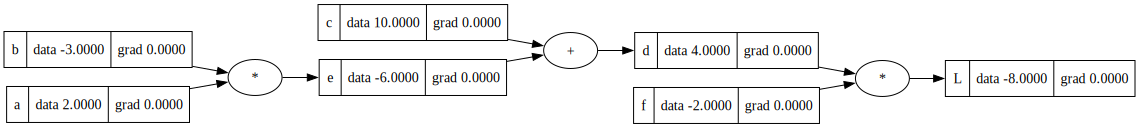

In [14]:
draw_dot(L)

In [12]:
def lol ():

    """
    function to calculate derivatives. 
    """
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')

    e = a*b; e.label = 'e' # for better tracing in the graph
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')

    e = a*b; e.label = 'e' # for better tracing in the graph
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L2 = L.data

    return (L2-L1)/h

lol()
# return gradient of loss wrt 'a' since a was bumped by 'h'. Similarly bump the variable wrt whhich the
# you want the gradient value. 
    

6.000000000000227

- using backprop and chainrule: 
L = h(d,f), so dL/dd, dL/df can be computed directly 

- Now lets go one node back. <br>
d = c + e <br>
dd/dc = 1 = dd/de<br>
dL/dc = dL/dd * dd/dc = f * 1 = f<br>
dL/de = dL/dd * dd/de = f * 1 = f<br>

- Now one more step __backward__: (_a, b_ remain)<br>
e = a * b 
de/da = b , de/db = a<br>
dL/da = dL/de*de/da (L can be directly expressed in terms of 'e' since we have calculated _that_ derivative in previous step)<br>
dL/da = f * b<br>
Similarly, dL/db = f * a





In [24]:
# lets set the gradients

a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
d.grad = -2.0
e.grad = -2.0
f.grad = 4.0
L.grad = 1.0 # grad wrt itself

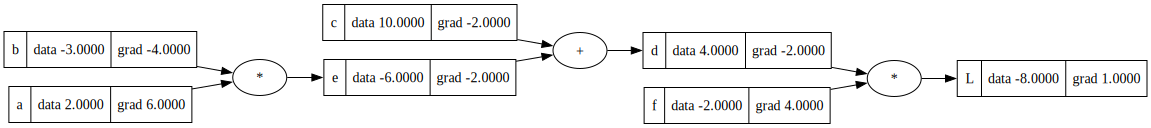

In [17]:
draw_dot(L)

Now lets tweak the inputs a,b,c,f in direction of their gradient (step_size) a bit and check how L responds. In a actual NN these will be the weights we usually have control over. 

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# run the forward pass again 

e = a*b 
d = c + e
L = d*f
L.data

-7.286496

__Inference__: <br>

|L| loss value has decreased from 8 to 7.28, hence our weights (a,b,c,f) are 'better' than the older values.
This illustrates one iteration of the forward-backward pass! <br>

Running this block over and over will further reduce the loss.. which will constitute the iterations 
of gradient descent. 

## Modelling a neuron

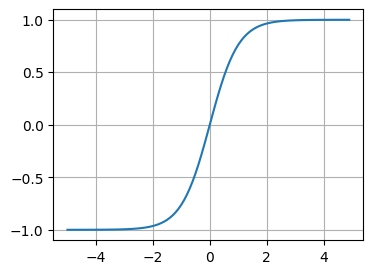

In [29]:
# tanh activation function 

import numpy as np 
import matplotlib.pyplot as plt

plt.figure(figsize=[4,3])
plt.plot(np.arange(-5,5, 0.1), np.tanh(np.arange(-5,5, 0.1)))
plt.grid()
plt.show()

Consider the simple neuron architecture with 2 inputs x1 and x2: 
![NEURON](images/neuron_model.jpeg)


In [40]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881373, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

`n.data` = 2, and tanh squishes 2 to 0.96 

To play around with squishing sensativity, modify the _bias_ higher or lower. From the graph of tanh it is clear the towards the ends the sensativity is quite low. (asymptotic behavour)
For nice number during backprop we will set it to 6.881371

In [47]:
# Now lets update the gradients 
# derivative of o wrt all inputs. Usually derivatives wrt to weights are of use to use in a NN. 

o.grad = 1.0 # derivative of o wrt o

# o = tanh(n) => do/dn = 1 - o^2

n.grad = 1 - (o.data)**2

# now backprop
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# derivative wrt weights
w2.grad = x2w2.grad*x2.data
w1.grad = x1w1.grad*x1.data

# derivative wrt input 
x1.grad = x1w1.grad*w1.data
x2.grad = x2w2.grad*w2.data

local derivative wrt tanh 

$\frac{d}{dx} \tanh(x) = 1 - \tanh^2(x)$

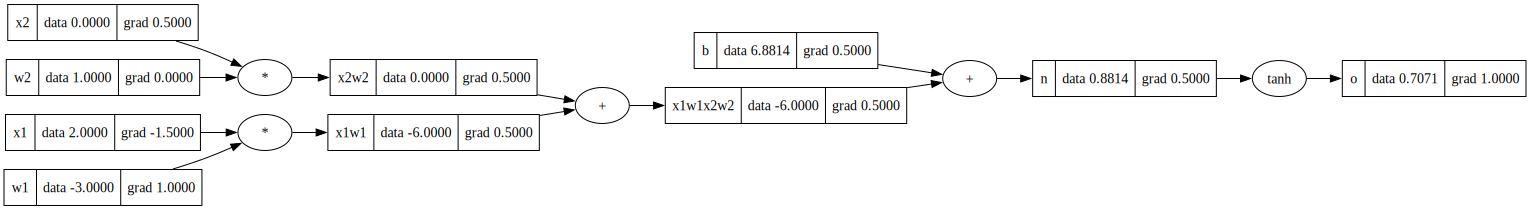

In [48]:
draw_dot(o)

So if we want the output `o` to increase, then w1 must be increased proportionally (since $\frac{do}{dw1} = 1$) while changing w2 has no effect since $\frac{do}{dw2} = 0$

Some observations in gradient calculation: 
- Over addition, the gradient of the output is carried over as it is to its constituents. i.e. if a = b+c, then a.grad = b.grad = c.grad
- Over multiplication: if a = b*c, then b.grad = a.grad * c.value

Now we go back to our Class value and add the automatic gradient calculation ability. 

In [89]:
class Value:

    def __init__(self, data, _children = () , _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # default value, assume L is not affected by w (node)
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        #__repr__ should return a printable representation of the object, most likely one of the ways possible to create this object. See official documentation here
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        sum = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += sum.grad*1
            other.grad += sum.grad*1
        sum._backward = _backward # not _backward() since it return nothing. we just need to store it temporarily. 
        return sum
    
    def __mul__(self, other):
        prod = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += prod.grad * other.data
            other.grad += prod.grad* self.data
        prod._backward = _backward 
        return prod
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh') # OUT is a child of self. 

        def _backward():
            self.grad += (1 - t**2) * out.grad # local grad * chain_rule_leftover.grad
            # self = Value(data = n); and self.gard = n.grad,,, NOT o.grad!
        out._backward = _backward # basically d(out)/dn -- 'backward'
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


Note:

Instead of overwriting these gradients when the variable name is overloaded, we need to _accumulate_ them. (i.e. instead of grad = ... we use grad += ... ) -- check example much below at the end of the notebook. 

So we go in the Value() class and change the grad calculation to enforce the above change. 

<hr>

Initialize all the variables and weights again such that grad is 0. Now we will call the _backward() function to compute the derivatives automatically. 

In [66]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881373, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

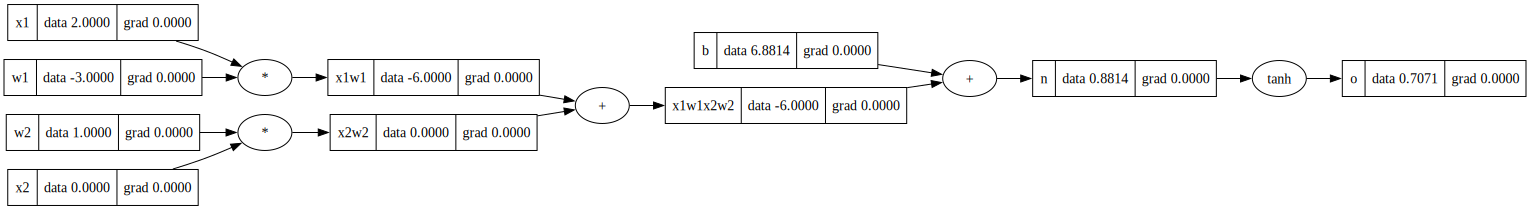

In [67]:
draw_dot(o)

Now lets call ._backward() in the right order. 
o -> n -> 

In [68]:
# initialize o.grad manually else chain rule will keep multiplying with default grad = 0.0 

o.grad = 1.0 
o._backward()

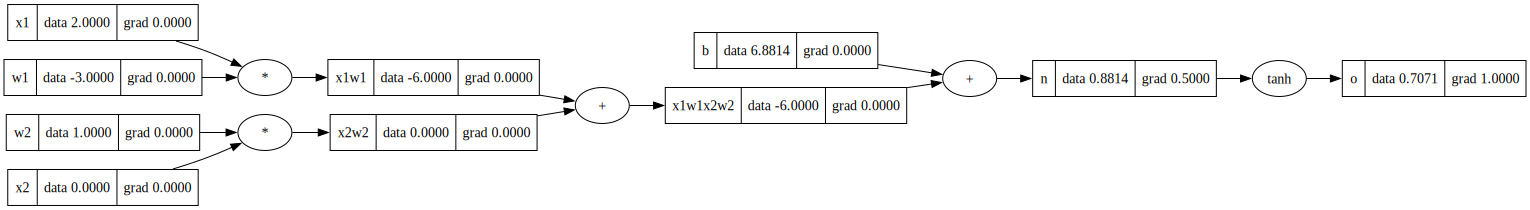

In [69]:
draw_dot(o)

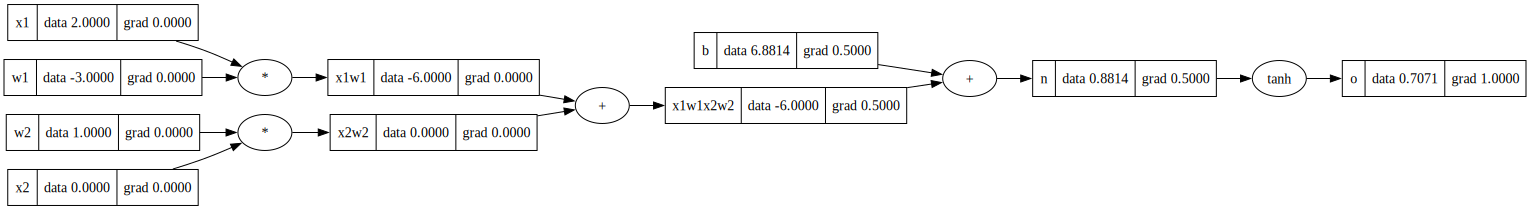

In [ ]:
n._backward() # defines gradient for x1w1x2w2 and b. 
draw_dot(o)

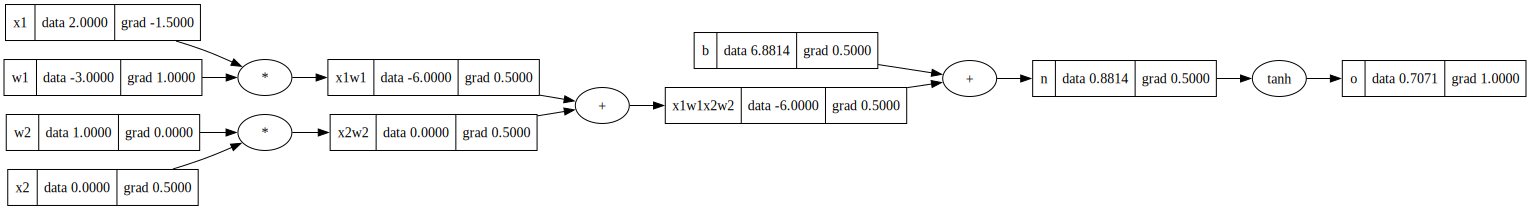

In [72]:
# similarly continuing along the 'grapevine'

b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

Now we want to automate this process of calling gradient backwards _in the right order_. We will use a `topological sort` for this. 

Where starting `o`, we create a list which tracks its previous nodes, their previous nodes and so on so that gradients are calculated in the right order. 

In [74]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373),
 Value(data=0.881373),
 Value(data=0.7071064876766542)]

In [77]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881373, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

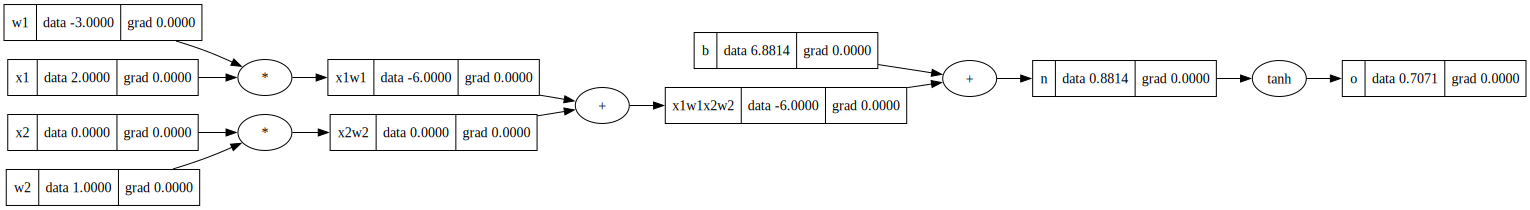

In [79]:
draw_dot(o)

In [83]:
# so essentially, this is what we have done: 

o.grad = 1 # base case 

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()


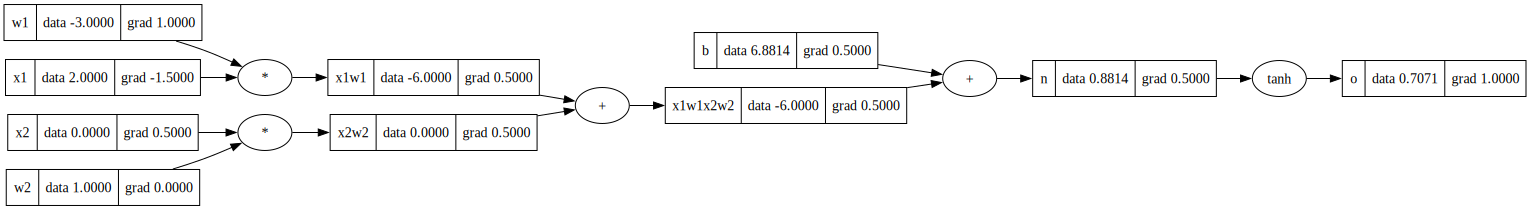

In [85]:
draw_dot(o)

# voilà all gradients have been calculated in the correct order through this one smooth step. 1

Note: We can add this in the backward() function in our `value` class as such as simple call o.backward() finally!

We have fucked up a bit: 

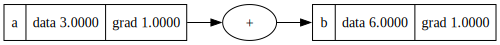

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

gradient should be 2, but two times a is being over-written as self and other are the same = out.grad * 1, if we go check about in the  `def __add__()` function 

Instead of overwriting these gradients when the variable name is overloaded, we need to _accumulate_ them. (i.e. instead of grad = ... we use grad += ... )

So we go in the Value() class and change the grad calculation to enforce the above change. 

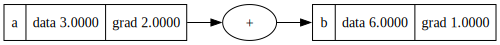

In [90]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

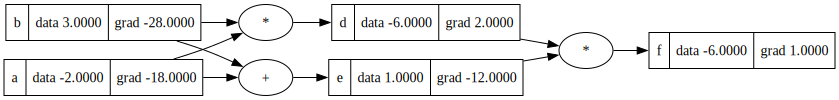

In [92]:
# another example of possible variable name overloading, but handled correctly after += modification

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

More topics discussed: reverse multiplication `__rmul__` and operating with normal integers and float by wrapping them. 

(to be continued in next notebook)